## BFast example notebook

This notebook collects some examples and provides more details on how to use BFast efficiently, as well as how to use it with distributed recources, i.e. multiple-GPUs (on a single node). For an example of multi-node multi-gpu use, see the scripts provided in the scripts folder of the repository.

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

import jax
import jax.numpy as jnp
import BFast
from BFast.core.jax_utils import show_hlo_info
import matplotlib.pyplot as plt
%matplotlib inline

We consider bispectrum estimation in three dimensions

In [2]:
dim = 3
res = 256
boxsize = 1000.

We compute the bispectrum up to the estimator limit of $k_{\rm{max}} = \frac{2}{3}k_{\rm{Nyquist}}$.

BFast expects bin edges in units of the fundamental mode $k_{F} = \frac{2*\pi}{L}$, where $L$ is the boxsize.

To compute the bispectrum up to said limit, with a linear binning of width $3k_{\rm{F}}$, we can take the following binning:

In [3]:
bins = jnp.arange(1, res//3, 3)
nbins = bins.shape[0] - 1
nbins

27

The closed (and nearly-closed ('open')) triangle configurations of bins can be obtained as follows, and yields 2276 triangle configurations for this binning

In [4]:
%time B_info = BFast.get_triangles(bins, open_triangles=True)
B_info['triangle_centers'].shape

CPU times: user 619 ms, sys: 76.5 ms, total: 696 ms
Wall time: 1.05 s


(2276, 3)

Let's load a field to compute the bispectrum of

This is a density field from the Quijote simulations, with resolution $256^3$ and boxsize $1000$ Mpc/h

In [6]:
field = jnp.load('df_m_256_PCS_z=0.npy')

### Single bispectrum estimation

To estimate the bispectrum, we provide two different implementations of the algorithm.

The fast (```fast=True```) algorithm precomputes the binned fields, and then loops over triangle configurations.
Storing the binned fields obviously comes with a memory cost.

The slower algorithm instead (smartly) recomputes the binned fields per triangle configuration, saving a significant amount of memory at high resolution and/or many bins.

The high-level function ```BFast.Bk``` computes the triangle configuration, bispectrum normalization, and estimates the bispectrum, given some binning.

When the argument ```Only_B=False``` is passed, the code will also estimate the power spectrum of the bins, which can be useful for shot-noise subtraction/modeling.

The codes outputs a dictionary with the triangle centers of the configurations (now in units of h/Mpc), the corresponding bispectrum ```'Bk'```, and when ```Only_B=False``` the power spectrum ```'Pk'```

The timings shown below are for a single NVIDIA A100 with 64GB of memory.


In [7]:
%time results_fast = BFast.Bk(field, boxsize, bins, fast=True, jit=True, only_B=False)
%timeit BFast.Bk(field, boxsize, bins, mas_order=4, fast=True, jit=True, only_B=False)
results_fast.keys()

CPU times: user 1.05 s, sys: 341 ms, total: 1.39 s
Wall time: 1.53 s
692 ms ± 137 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


dict_keys(['Bk', 'Pk', 'triangle_centers'])

In [8]:
%time results_slow = BFast.Bk(field, boxsize, bins, fast=False, jit=True)
%time BFast.Bk(field, boxsize, bins, fast=False, jit=True);

CPU times: user 7.51 s, sys: 22.2 ms, total: 7.53 s
Wall time: 7.75 s
CPU times: user 6.91 s, sys: 3.23 ms, total: 6.91 s
Wall time: 6.93 s


### Repeated bispectrum estimations

One may also want to compute the bispectrum for multiple fields. In this case using the high-level function ```BFast.Bk``` is wasteful, as the triangle configurations and corresponding bispectrum normalization only have to be computed once.

In this case, one can use the lower-level function ```BFast.bispectrum``` to once precompute the normalization (with ```compute_norm=True```), given the triangle configurations obtained above using ```BFast.get_triangles```. A jit version is already made available with ```BFast.bispectrum.jit```.

As expected it is roughly twice as fast as ```BFast.Bk```, because it does not compute the normalization:

In [9]:
norm = BFast.bispectrum.jit(field, boxsize, **B_info, fast=True, compute_norm=True, only_B=False)
%time results_unnormalized = BFast.bispectrum.jit(field, boxsize, **B_info, fast=True, compute_norm=False, only_B=False)
%timeit BFast.bispectrum.jit(field, boxsize, **B_info, fast=True, compute_norm=False)

CPU times: user 370 ms, sys: 173 ms, total: 542 ms
Wall time: 584 ms
329 ms ± 157 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


The normalized bispectra and power spectra can then be obtained by normalizing with the precomputed norm

In [10]:
results_normalized = {}
results_normalized['Pk'] = results_unnormalized['Pk']/norm['Pk']
results_normalized['Bk'] = results_unnormalized['Bk']/norm['Bk']

And we can check whether all results so far agree

In [11]:
for key in results_normalized.keys():
    assert jnp.allclose(results_fast[key], results_slow[key])
    assert jnp.allclose(results_fast[key], results_normalized[key], rtol=5e-4)
    print(key,'are the same')

Pk are the same
Bk are the same


Finally, let's check the memory usage:

--------  Memory usage of bispectrum  ---------
const : 68 B
code  : 39.5 kB
temp  : 1.9 GB
arg   : 64.1 MB
output: 35.7 kB
alias : 0 B
peak  : 2.0 GB


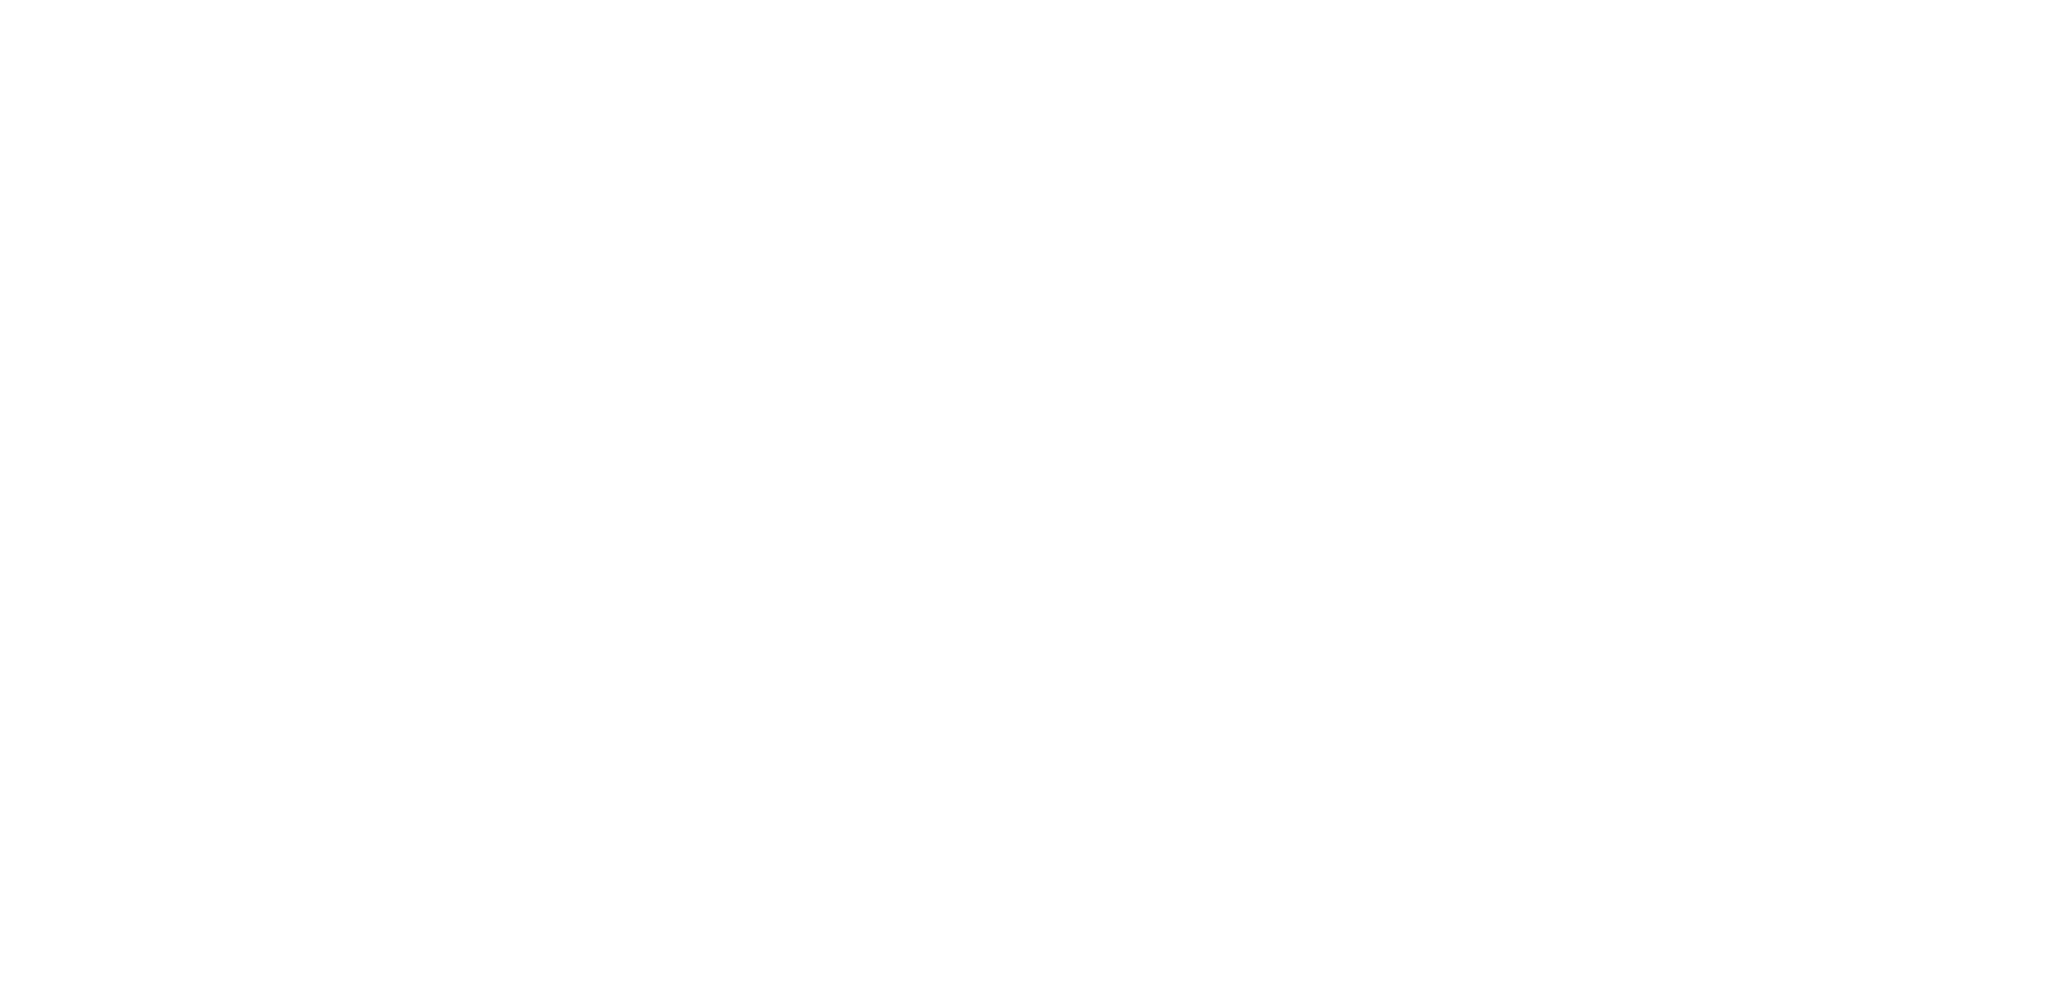

--------  Memory usage of bispectrum  ---------
const : 64 B
code  : 44.5 kB
temp  : 417.3 MB
arg   : 64.1 MB
output: 35.7 kB
alias : 0 B
peak  : 481.3 MB


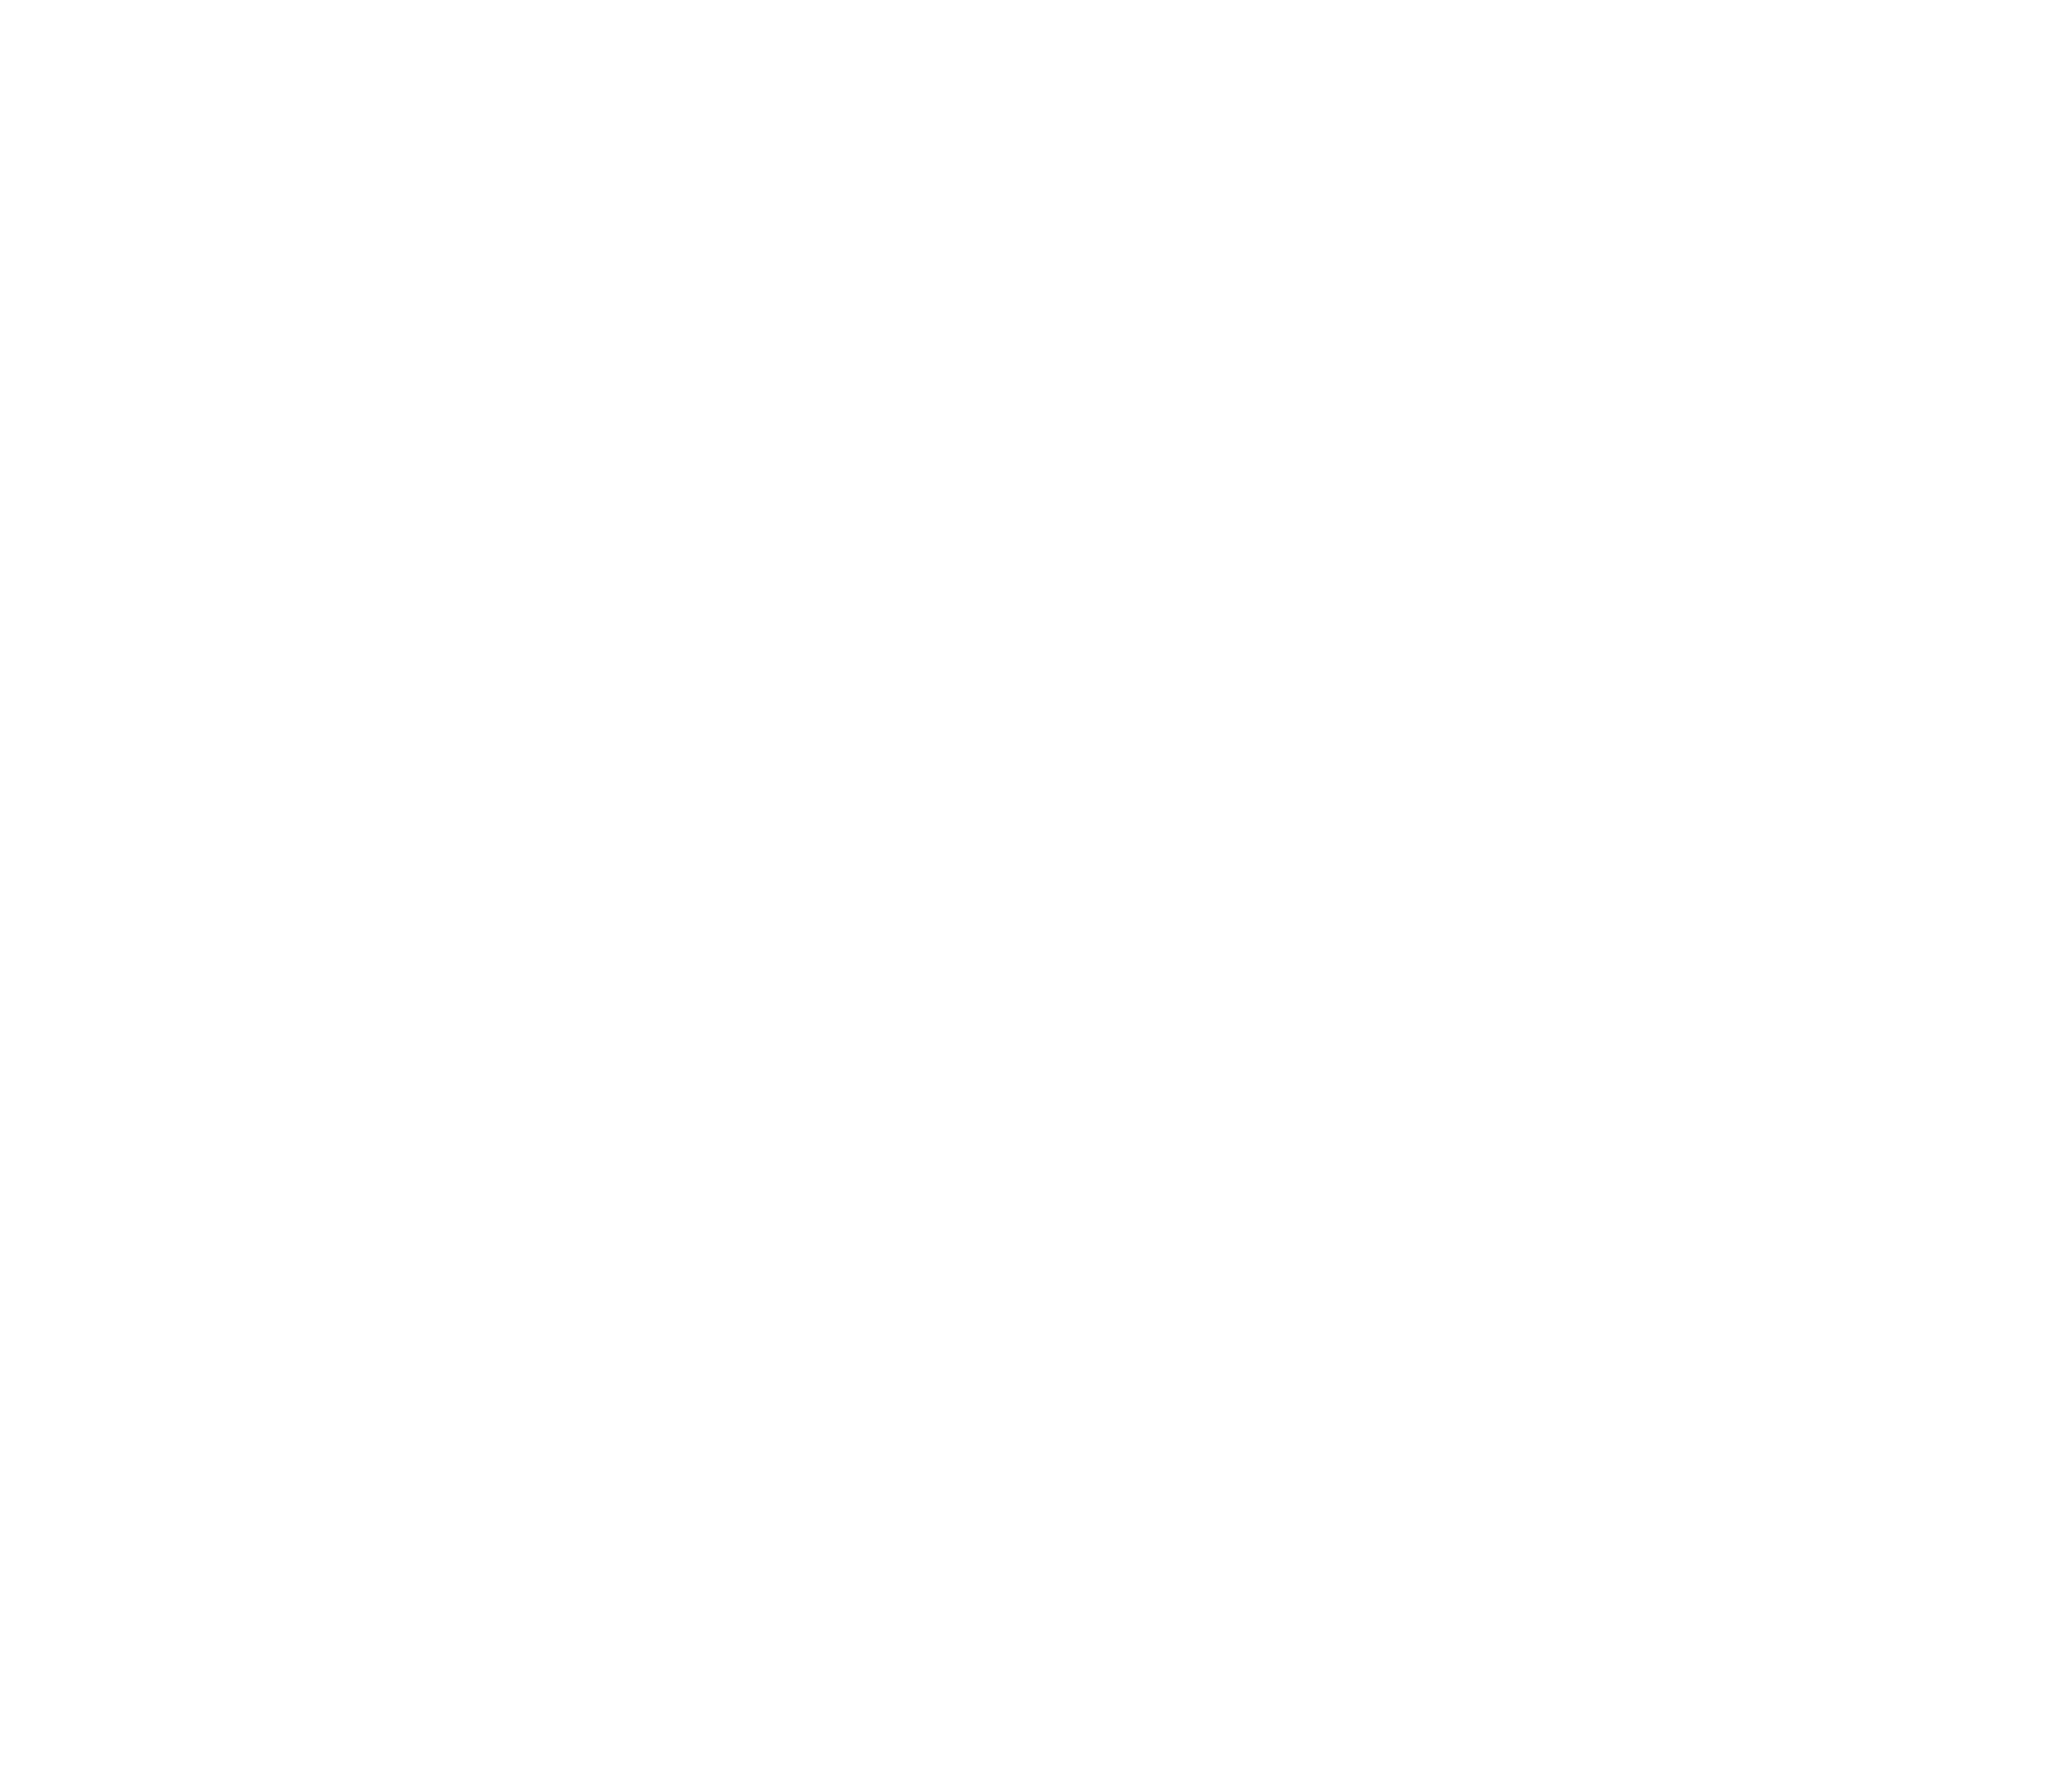

In [12]:
show_hlo_info(BFast.bispectrum.jit, field, boxsize, **B_info, fast=True, only_B=False, width=0)
show_hlo_info(BFast.bispectrum.jit, field, boxsize, **B_info, fast=False, only_B=False, width=0)

We see that the slow algorithm uses less than a quarter of the memory, at the cost of being almost 10 times as slow.

### Sharded (Multi-GPU)

In three dimension, for large fields, one might want to distribute the calculation over multiple devices/GPUs, to reduce the memory footprint.

To this end, we use the convenient sharding functionality of jax.
For the high-level function ```BFast.Bk```, the user only has to pass ```jit=True, sharded=True```, and the code will automatically distribute the calculation over all devices that jax has detected (i.e. those reported by ```jax.devices()```). To change the amount of devices used, simply set the available devices through the environment variable ```CUDA_VISIBLE_DEVICES```, before launching the code.

In our case, we see that we have four devices available

In [13]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

We can now simply run the estimator as before, with ```jit=True, sharded=True```

In [14]:
%time results_fast_sharded = BFast.Bk(field, boxsize, bins, fast=True, jit=True, sharded=True, only_B=False)
%timeit BFast.Bk(field, boxsize, bins, fast=True, jit=True, sharded=True, only_B=False)

CPU times: user 2.23 s, sys: 2.81 s, total: 5.04 s
Wall time: 4.05 s
310 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


For the case of repeated bispectrum calculations, the user has manually provide the sharded field and sharding details to```BFast.bispectrum.jit```.

To simplify this as much as possible, we provide the function ```BFast.shard_3D_array```, which can then be passed together with the ```sharding``` argument to ```BFast.bispectrum.jit```. 

***Note that for a properly distributed computation, one has to use the jitted version!***

In [15]:
field = BFast.shard_3D_array(field)
sharding = field.sharding

--------  Memory usage of bispectrum  ---------
const : 104 B
code  : 70.3 kB
temp  : 505.7 MB
arg   : 16.1 MB
output: 35.6 kB
alias : 0 B
peak  : 505.3 MB


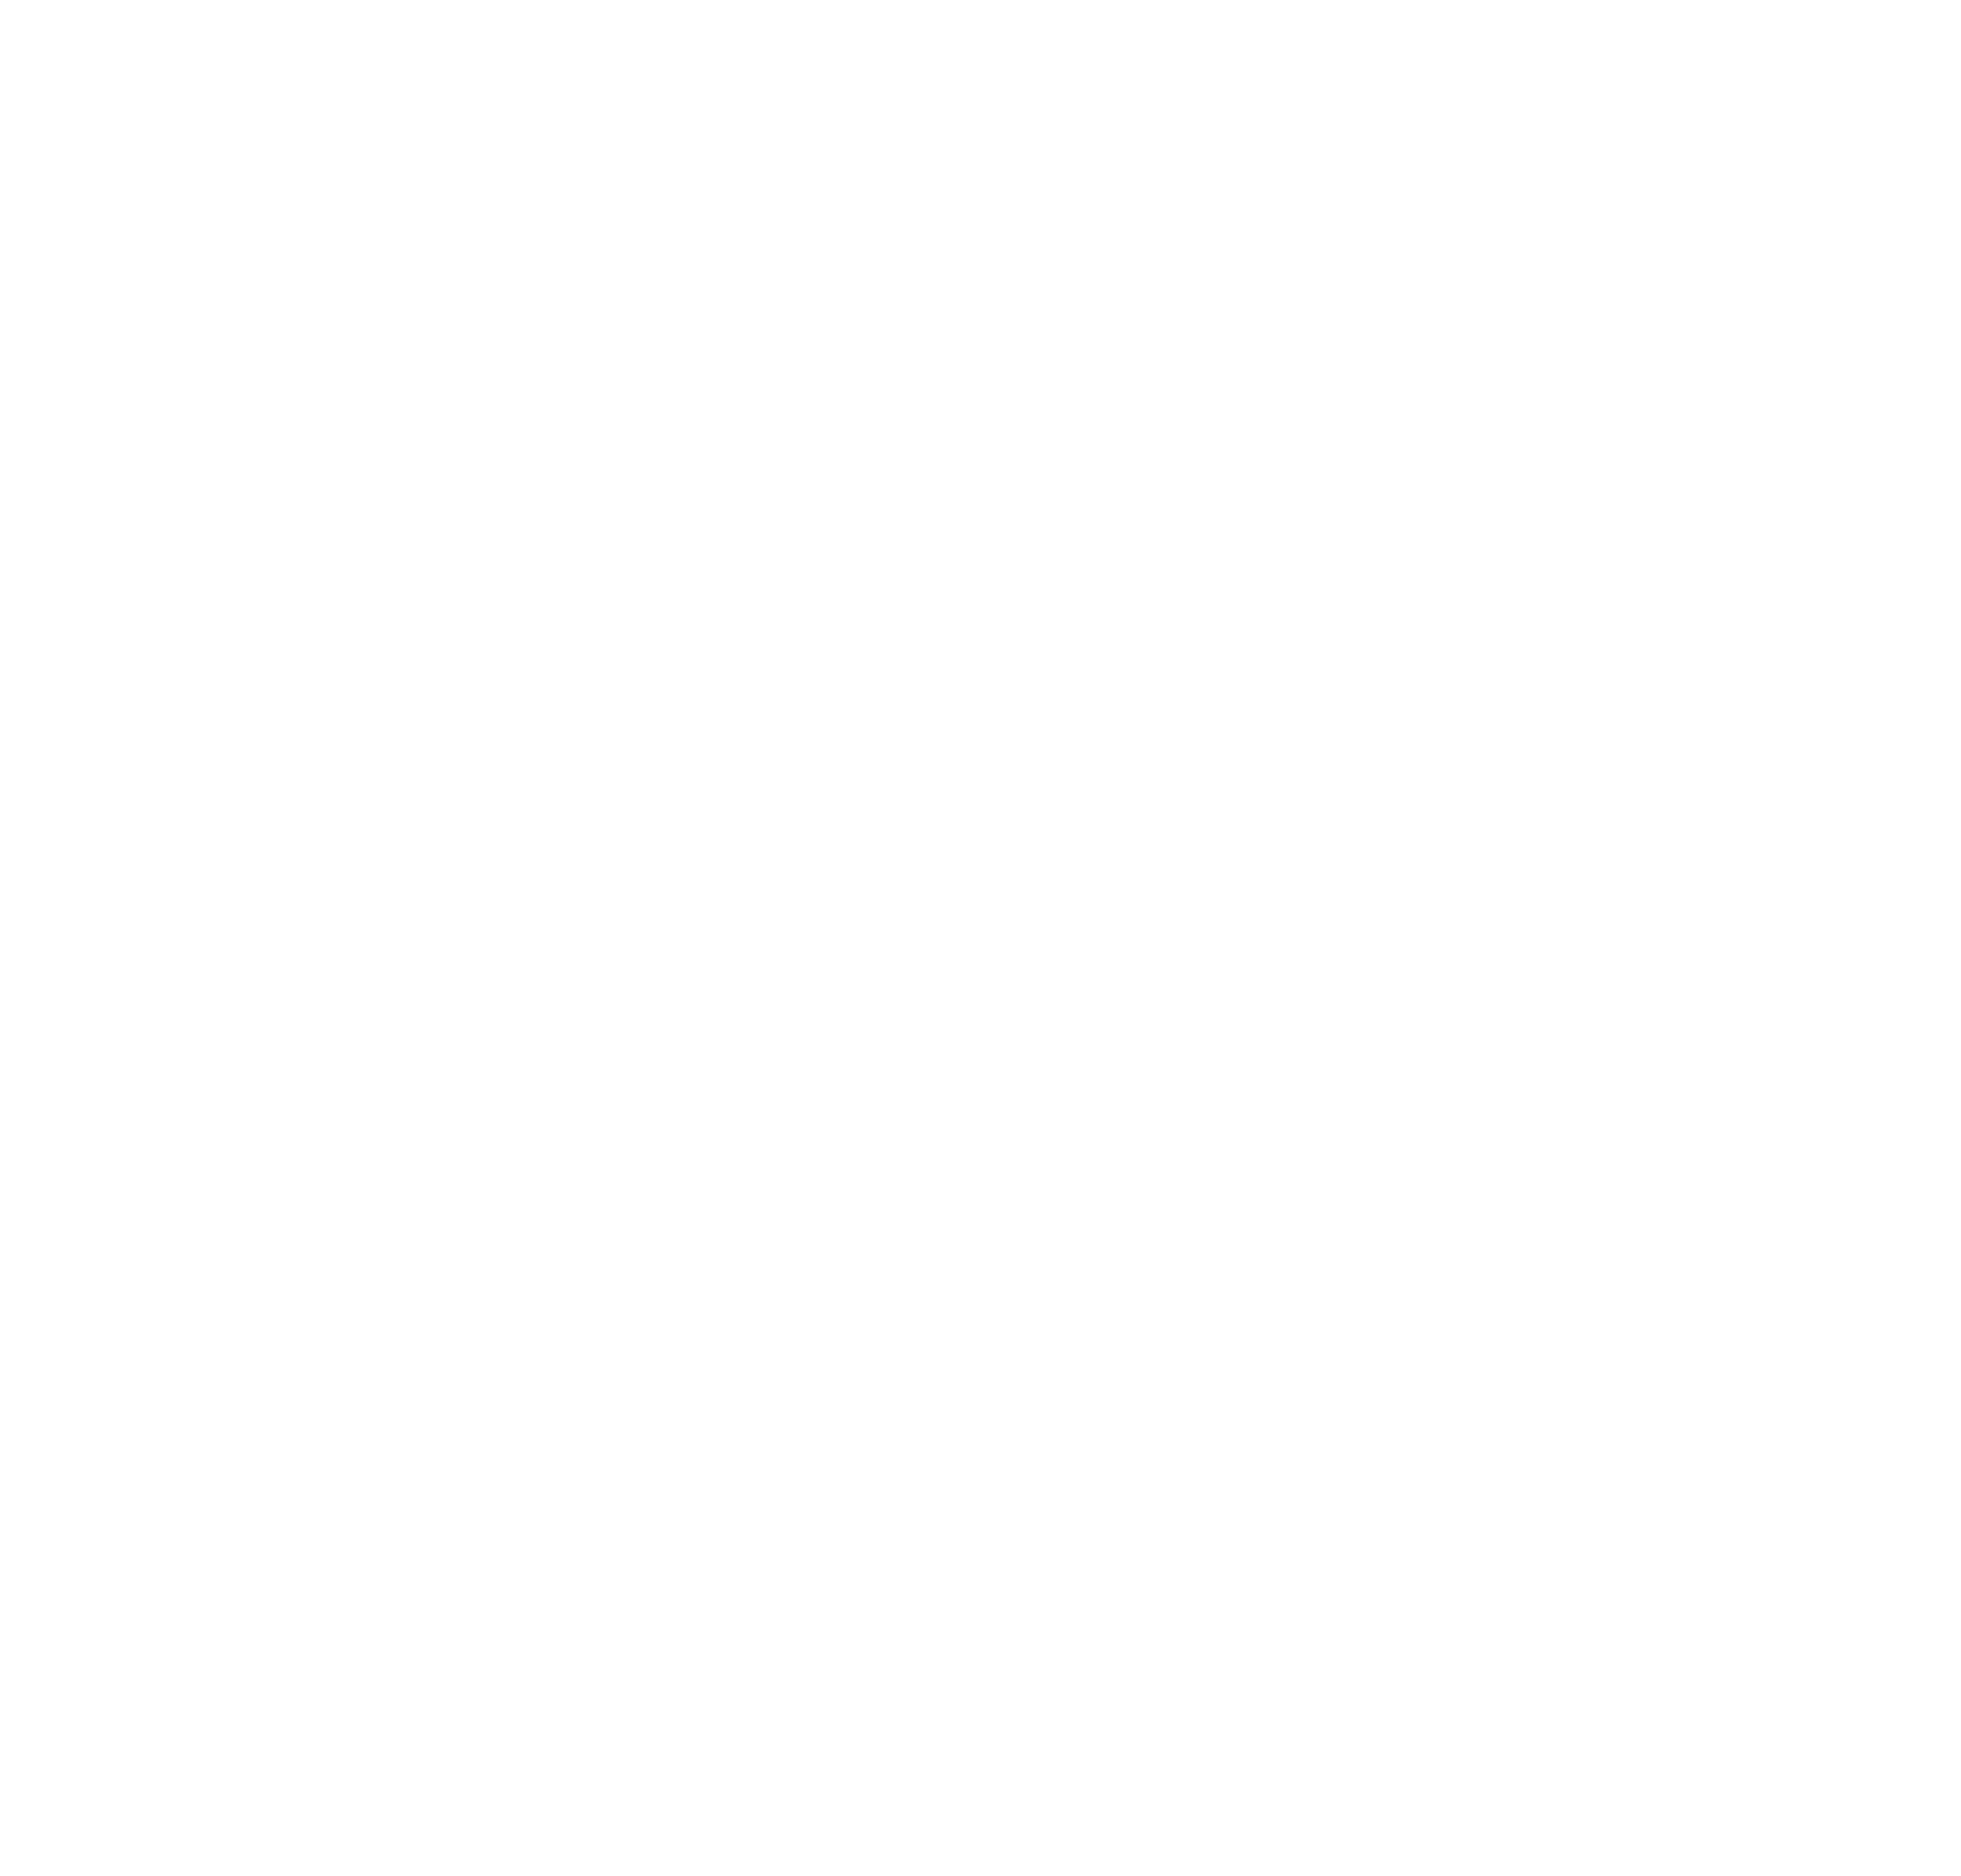

In [16]:
show_hlo_info(BFast.bispectrum.jit, field, boxsize, **B_info, mas_order=2, sharding=sharding, fast=True, width=0)

In [17]:
%time BFast.bispectrum.jit(field, boxsize, **B_info, fast=True, compute_norm=False, only_B=False, sharding=sharding)
%timeit BFast.bispectrum.jit(field, boxsize, **B_info, fast=True, compute_norm=False, only_B=False, sharding=sharding)

CPU times: user 711 ms, sys: 246 ms, total: 957 ms
Wall time: 635 ms
146 ms ± 70.1 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
for key in results_normalized.keys():
    assert jnp.allclose(results_fast[key], jax.device_get(results_fast_sharded[key]),rtol=5e-4)
    print(key,'are the same')

Pk are the same
Bk are the same


We see that for this case, we get a factor >2 speedup and of course a quarter of the memory footprint per device!

Finally, let's try something more impressive

In [19]:
dim = 3
res = 840
boxsize = 1000.

In [20]:
bins = jnp.arange(1, res//3, 3)
nbins = bins.shape[0] - 1
nbins

92

In [21]:
%time B_info = BFast.get_triangles(bins, open_triangles=True)
B_info['triangle_centers'].shape

CPU times: user 663 ms, sys: 27.9 ms, total: 691 ms
Wall time: 1.07 s


(72289, 3)

In [22]:
field = jax.random.normal(jax.random.PRNGKey(2),(res,)*dim, dtype=jnp.float32)
field = BFast.shard_3D_array(field)

--------  Memory usage of bispectrum  ---------
const : 68 B
code  : 61.0 kB
temp  : 53.3 GB
arg   : 566.9 MB
output: 1.1 MB
alias : 0 B
peak  : 53.3 GB


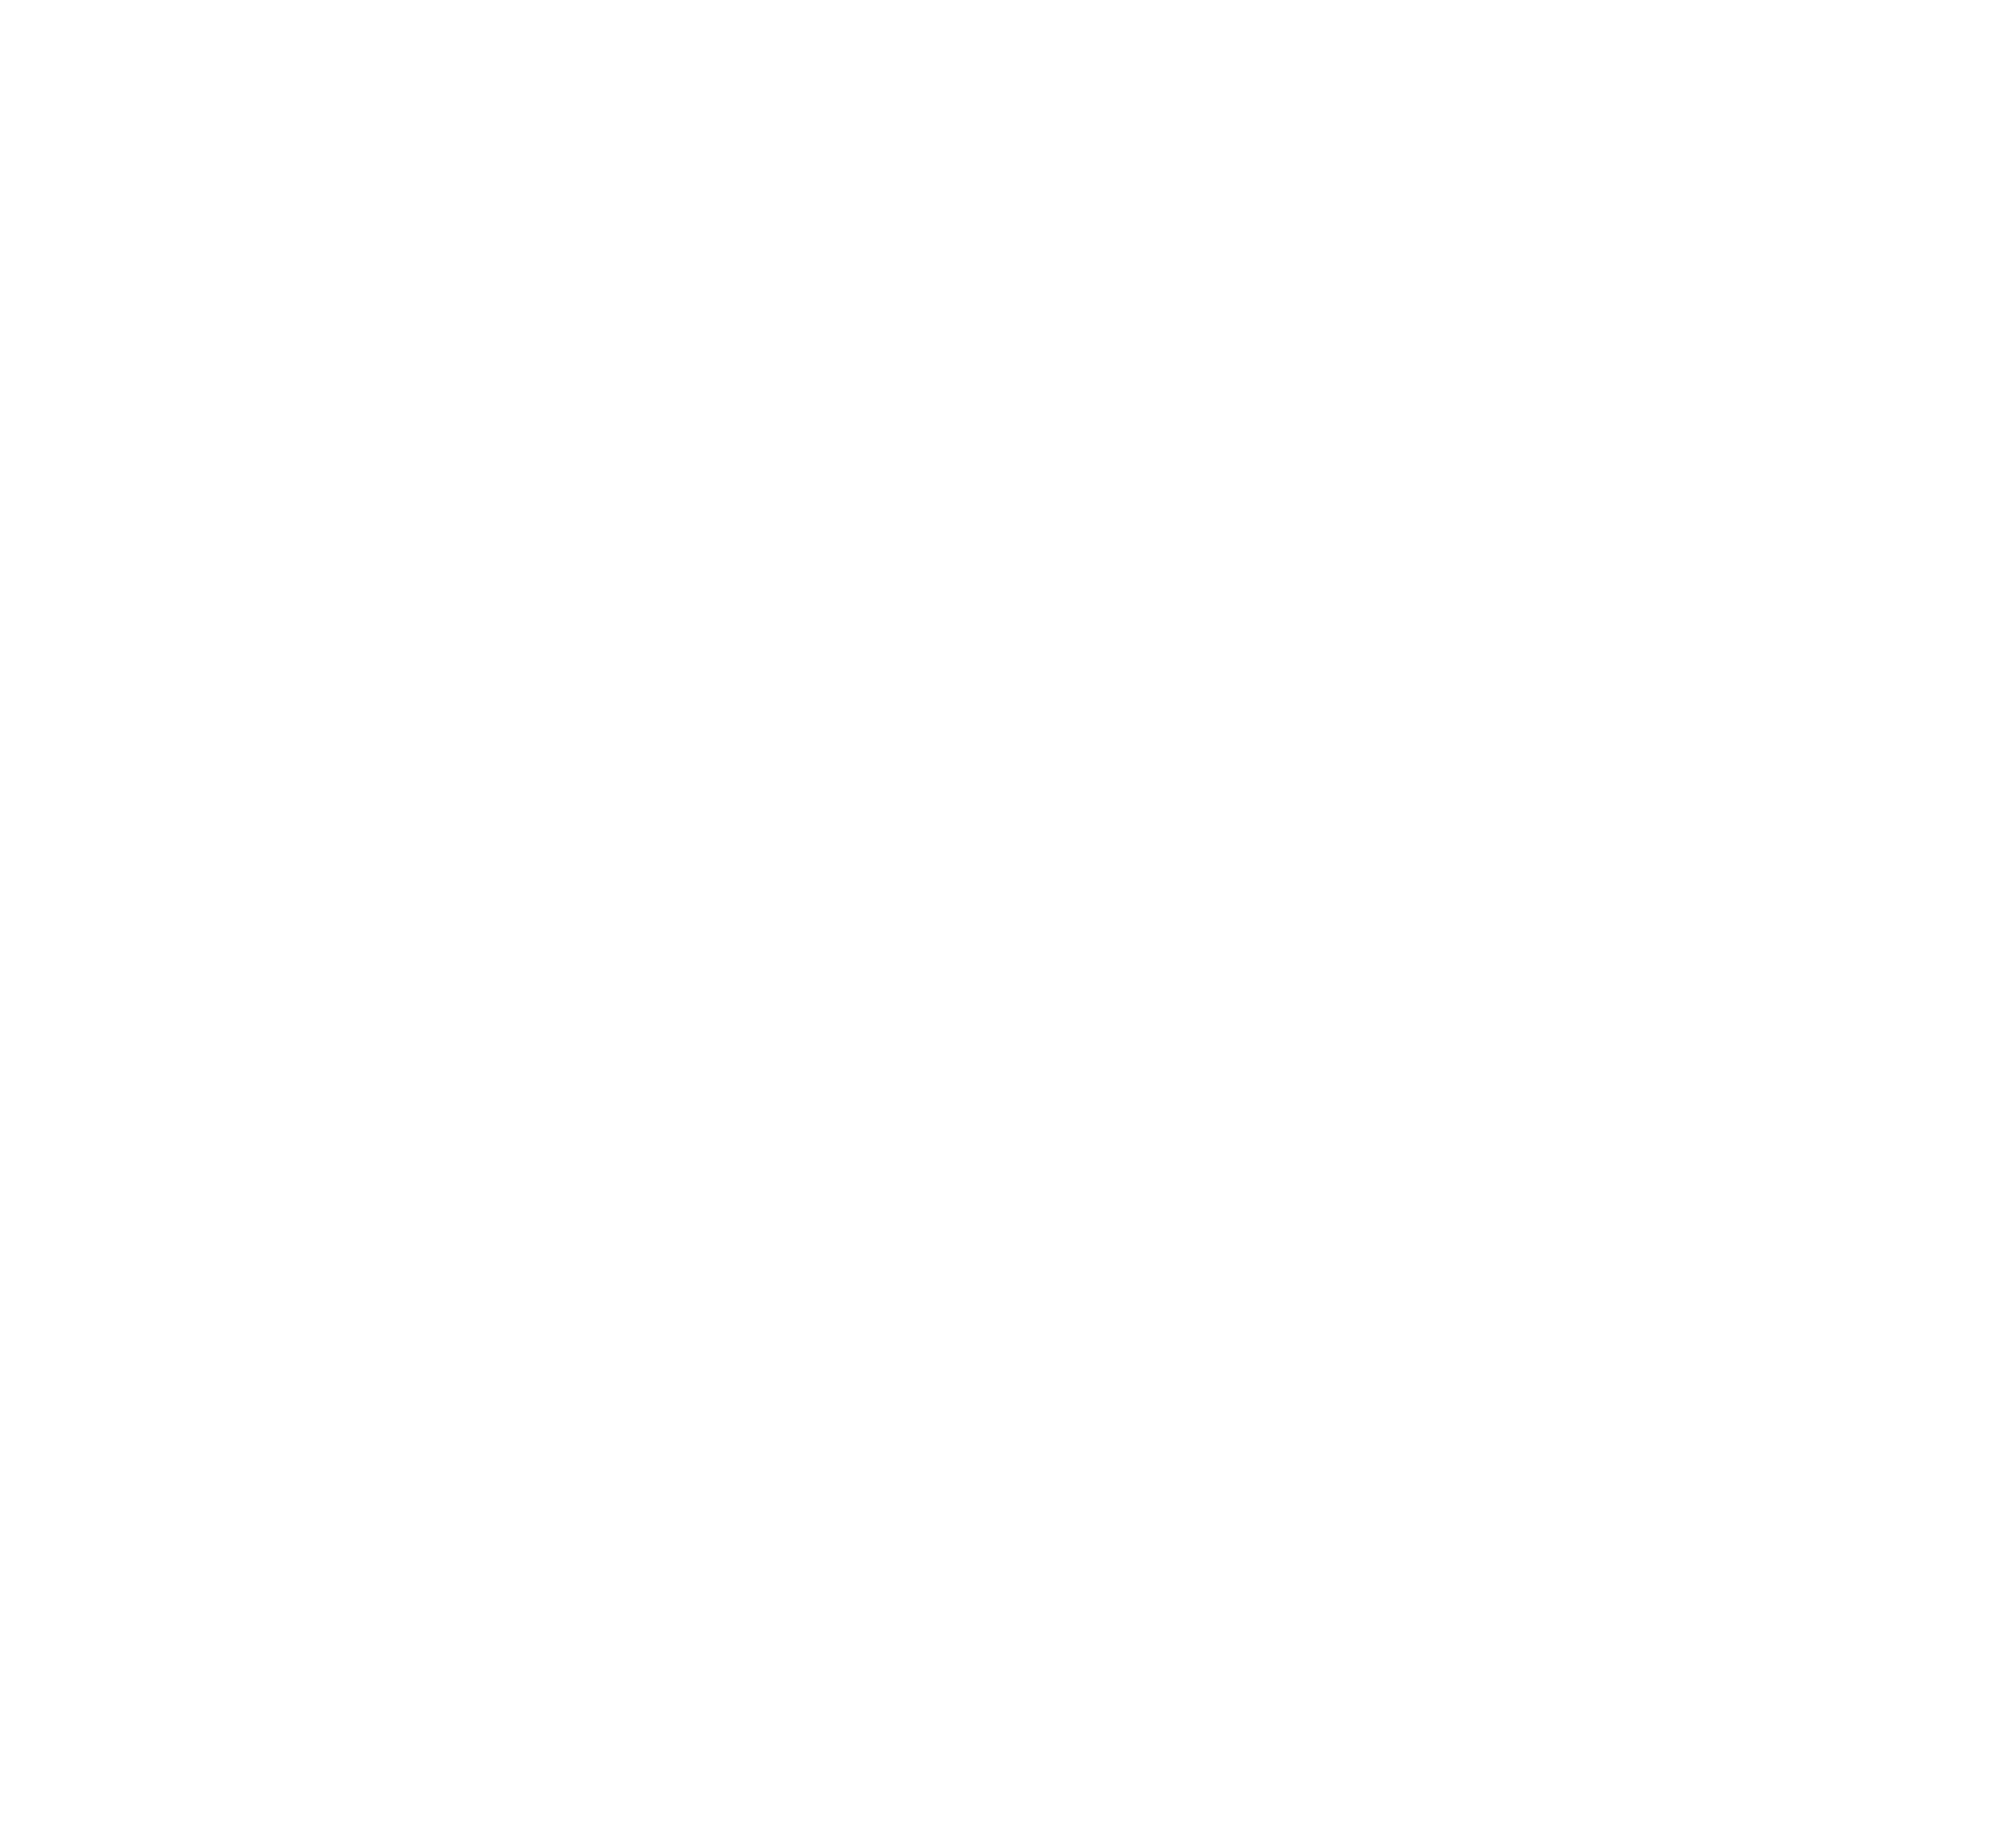

--------  Memory usage of bispectrum  ---------
const : 64 B
code  : 66.1 kB
temp  : 4.7 GB
arg   : 566.9 MB
output: 1.1 MB
alias : 0 B
peak  : 4.2 GB


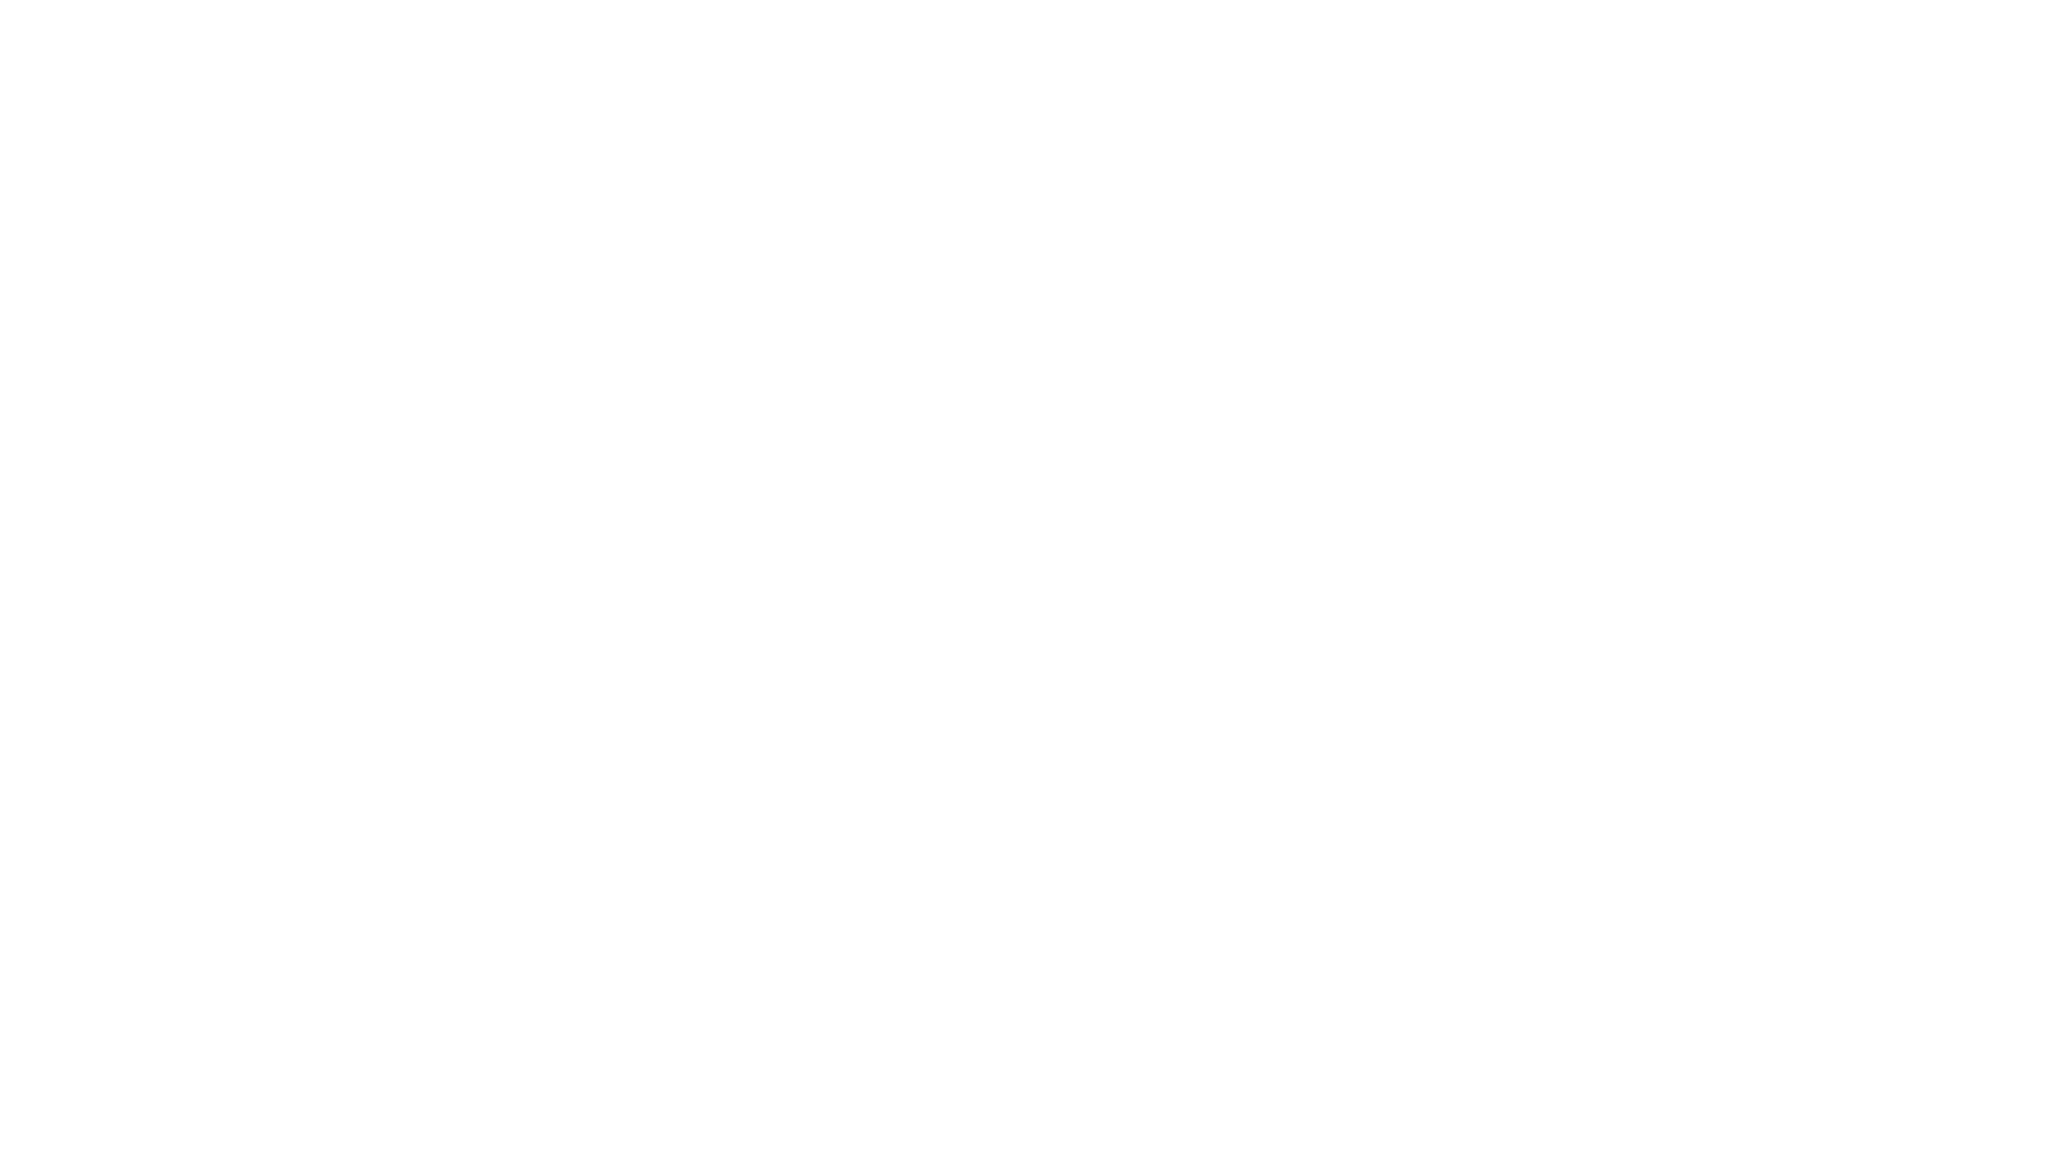

In [23]:
show_hlo_info(BFast.bispectrum.jit, field, boxsize, **B_info, fast=True, only_B=False, sharding=field.sharding, width=0)
show_hlo_info(BFast.bispectrum.jit, field, boxsize, **B_info, fast=False, only_B=False, sharding=field.sharding, width=0)

In [24]:
%time BFast.bispectrum.jit(field, boxsize, **B_info, fast=True, compute_norm=False, only_B=False, sharding=field.sharding);

CPU times: user 2min 35s, sys: 3min 7s, total: 5min 43s
Wall time: 1min 26s


We see that the fast algorithm can be used to compute $72289$ triangles at a resolution of $840^3$ in less than 1.5 minutes using 4 GPUs!